## Transak EDA with seaborn 

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import seaborn as sns


In [2]:
bq = bigquery.Client(project="af-finanzen")
# query = ("""
#     SELECT
#       description
#       -- , Konto
#       , CASE 
#           WHEN Konto in ("PK Auto", "PK Maja", "PK Rest", "SK Haushalt", "Top-Up") THEN "Others"
#           ELSE Konto
#         END as Konto
#     FROM banks.revolut_mapping_internal
# """)
query = ("""
    SELECT
         R.*
         , CASE 
           WHEN Konto in ("PK Auto", "PK Maja", "PK Rest", "SK Haushalt", "Top-Up") THEN "Others"
           ELSE Konto
         END as konto
    FROM banks.revolut_v R
    LEFT JOIN banks.revolut_mapping_internal RMI
         ON R.description = RMI.description
""")
df = bq.query(query).to_dataframe()  # API request


In [3]:
df.head()

type  product             started           completed  \
0      TRANSFER  Current 2021-07-21 15:57:10 2021-07-21 16:00:45   
1  CARD_PAYMENT  Current 2022-12-28 07:24:44 2022-12-29 13:04:22   
2  CARD_PAYMENT  Current 2023-03-29 16:34:57 2023-03-30 10:18:53   
3         TOPUP  Current 2022-04-25 21:46:15 2022-04-25 21:46:18   
4  CARD_PAYMENT  Current 2023-08-22 14:42:32 2023-08-23 14:07:49   

                                     description         amount          fee  \
0  To Gabinet Psychoterapii Edyta Kilian-Grudnik  -42.510000000  0.710000000   
1                                         Adamek   -2.330000000         0E-9   
2                                          Conad  -24.870000000         0E-9   
3                     Google Pay Top-Up by *4356   75.000000000         0E-9   
4                                          Dunas  -70.530000000         0E-9   

  currency      state        balance account    month       first_started  \
0      CHF  COMPLETED  350.970000000     CHF  2021-07 2021-07-21 15:57:10   
1      CHF  COMPLETED  371.940000000     CHF  2022-12 2022-12-28 07:24:44   
2      CHF  COMPLETED  195.300000000     CHF  2023-03 2023-03-29 16:34:57   
3      CHF  COMPLETED  130.690000000     CHF  2022-04 2022-04-25 21:46:15   
4      CHF  COMPLETED   71.670000000     CHF  2023-08 2023-08-22 14:42:32   

       konto  
0   PK Leben  
1   PK Leben  
2  SK Ferien  
3     Others  
4  SK Ferien

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   type           1883 non-null   object        
 1   product        1883 non-null   object        
 2   started        1883 non-null   datetime64[ns]
 3   completed      1880 non-null   datetime64[ns]
 4   description    1883 non-null   object        
 5   amount         1883 non-null   object        
 6   fee            1883 non-null   object        
 7   currency       1883 non-null   object        
 8   state          1883 non-null   object        
 9   balance        1880 non-null   object        
 10  account        1883 non-null   object        
 11  month          1883 non-null   object        
 12  first_started  1883 non-null   datetime64[ns]
 13  konto          1883 non-null   object        
dtypes: datetime64[ns](3), object(11)
memory usage: 206.1+ KB


convert types

In [5]:
df.nunique()

type                7
product             1
started          1875
completed        1736
description       402
amount           1222
fee               166
currency            3
state               2
balance          1832
account             3
month              38
first_started     402
konto               5
dtype: int64

In [6]:
df.isnull().sum().sort_values(ascending=False)

completed        3
balance          3
type             0
product          0
started          0
description      0
amount           0
fee              0
currency         0
state            0
account          0
month            0
first_started    0
konto            0
dtype: int64

# Fill nulls

- balance with amount, because those are reverts from tests if card works
- completed with stared, same reason as balance

In [7]:
df.balance = df.balance.fillna(df.amount)
df.completed = df.completed.fillna(df.started)


In [8]:
df.konto.value_counts()

konto
Others       842
PK Leben     488
PK Reisen    258
PK Artur     178
SK Ferien    117
Name: count, dtype: int64

In [9]:
df.groupby('konto').konto.count()

konto
Others       842
PK Artur     178
PK Leben     488
PK Reisen    258
SK Ferien    117
Name: konto, dtype: int64

In [10]:
konto_mapping = {'Others': 1, 'PK Artur': 2, 'PK Leben': 3, 'PK Reisen': 4, 'SK Ferien':5 }

In [11]:
df['konto'] = df.konto.apply(lambda x: konto_mapping[x])

In [12]:
# One Hot encoding

In [13]:
df = pd.get_dummies(df, columns=['type', 'currency', 'state', 'account'])

In [14]:
df.amount = df.amount.astype(float)
df.fee = df.fee.astype(float)
df.balance = df.balance.astype(float)

# Cyclic transformations

df.started

In [15]:
df['started_day'] = df.started.dt.day
df['started_day_sin'] = np.sin((df.started_day-1)*(2.*np.pi/31))
df['started_day_cos'] = np.cos((df.started_day-1)*(2.*np.pi/31))
df['started_month'] = df.started.dt.month
df['started_month_sin'] = np.sin((df.started_month-1)*(2.*np.pi/12))
df['started_month_cos'] = np.cos((df.started_month-1)*(2.*np.pi/12))
df['started_year'] = df.started.dt.year
df.drop(columns=['started'], inplace=True)


df.completed

In [16]:
df['completed_day'] = df.completed.dt.day
df['completed_day_sin'] = np.sin((df.completed_day-1)*(2.*np.pi/31))
df['completed_day_cos'] = np.cos((df.completed_day-1)*(2.*np.pi/31))
df['completed_month'] = df.completed.dt.month
df['completed_month_sin'] = np.sin((df.completed_month-1)*(2.*np.pi/12))
df['completed_month_cos'] = np.cos((df.completed_month-1)*(2.*np.pi/12))
df['completed_year'] = df.completed.dt.year
df.drop(columns=['completed'], inplace=True)


df.first_started

In [17]:
df['first_started_day'] = df.first_started.dt.day
df['first_started_day_sin'] = np.sin((df.first_started_day-1)*(2.*np.pi/31))
df['first_started_day_cos'] = np.cos((df.first_started_day-1)*(2.*np.pi/31))
df['first_started_month'] = df.first_started.dt.month
df['first_started_month_sin'] = np.sin((df.first_started_month-1)*(2.*np.pi/12))
df['first_started_month_cos'] = np.cos((df.first_started_month-1)*(2.*np.pi/12))
df['first_started_year'] = df.first_started.dt.year
df.drop(columns=['first_started'], inplace=True)


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product                  1883 non-null   object 
 1   description              1883 non-null   object 
 2   amount                   1883 non-null   float64
 3   fee                      1883 non-null   float64
 4   balance                  1883 non-null   float64
 5   month                    1883 non-null   object 
 6   konto                    1883 non-null   int64  
 7   type_ATM                 1883 non-null   bool   
 8   type_CARD_PAYMENT        1883 non-null   bool   
 9   type_CARD_REFUND         1883 non-null   bool   
 10  type_EXCHANGE            1883 non-null   bool   
 11  type_FEE                 1883 non-null   bool   
 12  type_TOPUP               1883 non-null   bool   
 13  type_TRANSFER            1883 non-null   bool   
 14  currency_CHF            

In [19]:
df.columns

Index(['product', 'description', 'amount', 'fee', 'balance', 'month', 'konto',
       'type_ATM', 'type_CARD_PAYMENT', 'type_CARD_REFUND', 'type_EXCHANGE',
       'type_FEE', 'type_TOPUP', 'type_TRANSFER', 'currency_CHF',
       'currency_EUR', 'currency_PLN', 'state_COMPLETED', 'state_REVERTED',
       'account_CHF', 'account_EUR', 'account_PLN', 'started_day',
       'started_day_sin', 'started_day_cos', 'started_month',
       'started_month_sin', 'started_month_cos', 'started_year',
       'completed_day', 'completed_day_sin', 'completed_day_cos',
       'completed_month', 'completed_month_sin', 'completed_month_cos',
       'completed_year', 'first_started_day', 'first_started_day_sin',
       'first_started_day_cos', 'first_started_month',
       'first_started_month_sin', 'first_started_month_cos',
       'first_started_year'],
      dtype='object')

In [20]:
df.describe()

amount          fee      balance        konto  started_day  \
count  1883.000000  1883.000000  1883.000000  1883.000000  1883.000000   
mean      0.228455     0.205608   202.160738     2.272438    16.153478   
std     221.363135     0.810870   238.156851     1.319203     9.008340   
min   -2984.580000    -0.470000   -46.460000     1.000000     1.000000   
25%     -38.335000     0.000000    67.040000     1.000000     8.000000   
50%      -4.980000     0.000000   148.710000     2.000000    16.000000   
75%      40.000000     0.060000   249.365000     3.000000    24.000000   
max    3000.000000    16.910000  3150.480000     5.000000    31.000000   

       started_day_sin  started_day_cos  started_month  started_month_sin  \
count      1883.000000      1883.000000    1883.000000        1883.000000   
mean         -0.025922        -0.004382       6.970791          -0.066875   
std           0.679522         0.733546       3.323618           0.690311   
min          -0.998717        -0.994869       1.000000          -1.000000   
25%          -0.651372        -0.758758       4.000000          -0.866025   
50%           0.000000        -0.050649       7.000000           0.000000   
75%           0.651372         0.688967      10.000000           0.500000   
max           0.998717         1.000000      12.000000           1.000000   

       started_month_cos  ...  completed_month_sin  completed_month_cos  \
count       1.883000e+03  ...          1883.000000         1.883000e+03   
mean       -7.157461e-02  ...            -0.068904        -7.423506e-02   
std         7.172179e-01  ...             0.689823         7.172251e-01   
min        -1.000000e+00  ...            -1.000000        -1.000000e+00   
25%        -8.660254e-01  ...            -0.866025        -8.660254e-01   
50%        -1.836970e-16  ...             0.000000        -1.836970e-16   
75%         5.000000e-01  ...             0.500000         5.000000e-01   
max         1.000000e+00  ...             1.000000         1.000000e+00   

       completed_year  first_started_day  first_started_day_sin  \
count     1883.000000        1883.000000            1883.000000   
mean      2022.204461          20.281997              -0.152785   
std          0.827362           9.836475               0.626789   
min       2021.000000           1.000000              -0.998717   
25%       2022.000000          12.000000              -0.571268   
50%       2022.000000          23.000000              -0.394356   
75%       2023.000000          30.000000               0.394356   
max       2024.000000          31.000000               0.998717   

       first_started_day_cos  first_started_month  first_started_month_sin  \
count            1883.000000          1883.000000              1883.000000   
mean                0.305692             4.858205                 0.027173   
std                 0.700581             3.488796                 0.529100   
min                -0.994869             1.000000                -1.000000   
25%                -0.345523             1.000000                -0.500000   
50%                 0.528964             5.000000                 0.000000   
75%                 0.918958             8.000000                 0.500000   
max                 1.000000            12.000000                 1.000000   

       first_started_month_cos  first_started_year  
count              1883.000000         1883.000000  
mean                  0.122625         2021.428571  
std                   0.839524            0.732262  
min                  -1.000000         2021.000000  
25%                  -0.866025         2021.000000  
50%                   0.500000         2021.000000  
75%                   1.000000         2022.000000  
max                   1.000000         2024.000000  

[8 rows x 25 columns]

In [21]:
sns.pairplot(df)

c:\Users\admin\.conda\envs\af-finanzen\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\admin\.conda\envs\af-finanzen\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\admin\.conda\envs\af-finanzen\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\admin\.conda\envs\af-finanzen\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

histograms

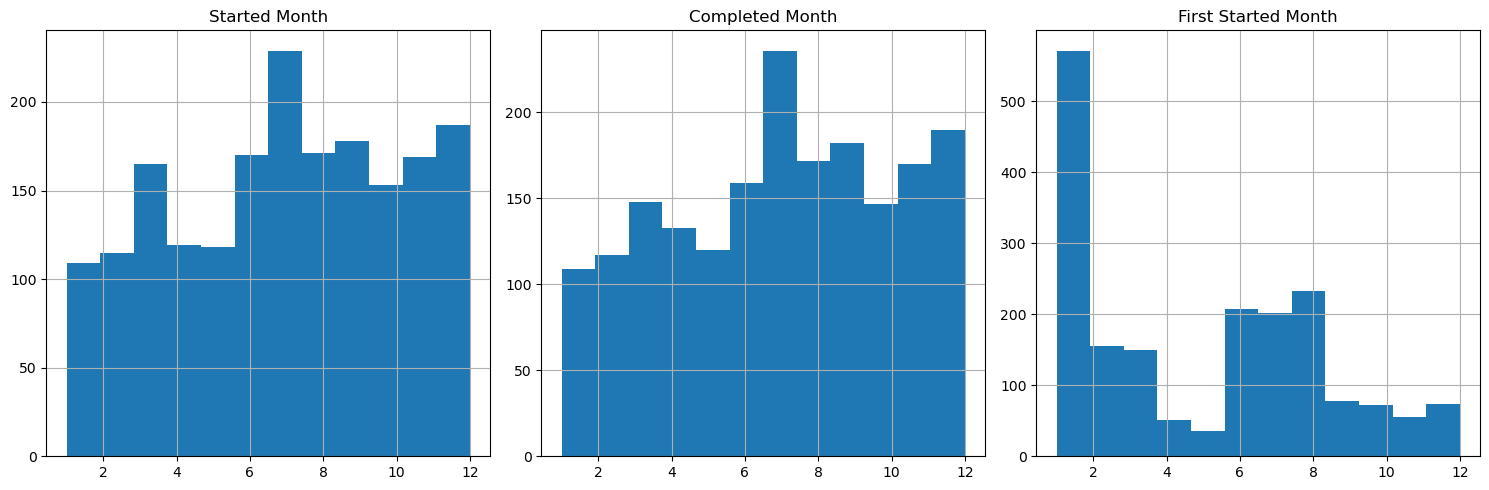

In [22]:
import matplotlib.pyplot as plt
#import pandas as pd

# Assuming 'df' is your pandas DataFrame
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create histograms for each column
df['started_month'].hist(bins=12, ax=axes[0])
df['completed_month'].hist(bins=12, ax=axes[1])
df['first_started_month'].hist(bins=12, ax=axes[2])

# Set titles for each subplot
axes[0].set_title('Started Month')
axes[1].set_title('Completed Month')
axes[2].set_title('First Started Month')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


<Axes: >

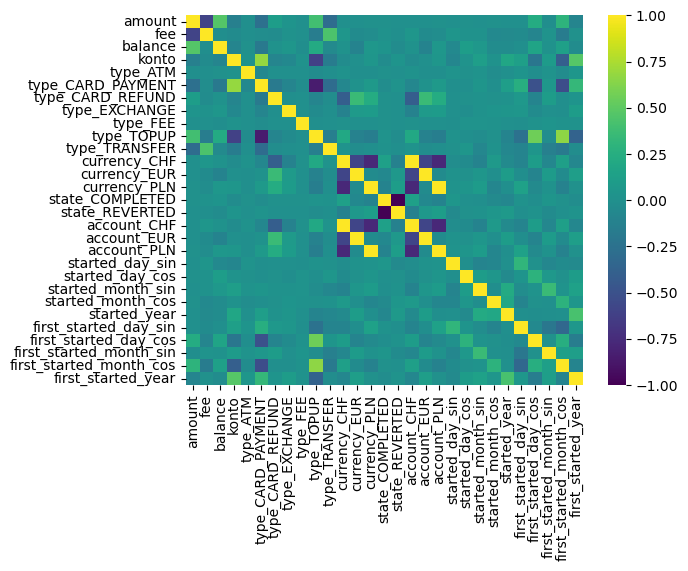

In [23]:
df_corr = df.drop(columns=['product', 'description', 'month', 'started_day', 'started_month', 'completed_day', 'completed_day_sin', 'completed_day_cos', 'completed_month', 'completed_month_sin', 'completed_month_cos', 'completed_year', 'first_started_day', 'first_started_month' ]
                  , axis=1)
#sns.heatmap(df_corr.corr(), annot=True, fmt="d", cmap="viridis")
sns.heatmap(df_corr.corr(), annot=False, cmap="viridis", xticklabels=True, yticklabels=True)
#sns.heatmap(df_corr.corr())


In [24]:
df_corr.columns

Index(['amount', 'fee', 'balance', 'konto', 'type_ATM', 'type_CARD_PAYMENT',
       'type_CARD_REFUND', 'type_EXCHANGE', 'type_FEE', 'type_TOPUP',
       'type_TRANSFER', 'currency_CHF', 'currency_EUR', 'currency_PLN',
       'state_COMPLETED', 'state_REVERTED', 'account_CHF', 'account_EUR',
       'account_PLN', 'started_day_sin', 'started_day_cos',
       'started_month_sin', 'started_month_cos', 'started_year',
       'first_started_day_sin', 'first_started_day_cos',
       'first_started_month_sin', 'first_started_month_cos',
       'first_started_year'],
      dtype='object')

# Save Features into BQ

In [25]:
table_path = 'banks.revolut_eda_features'
df_corr.to_gbq(table_path, project_id='af-finanzen', if_exists='replace')

100%|██████████| 1/1 [00:00<?, ?it/s]


## BigQuery train, evaluation, test split

Calculate cardinality to choose least used column but with biggest cardinality as a split key. Usually a date is a good candidate.

In [26]:
(df_corr.nunique() / len(df_corr)).sort_values(ascending=False)


balance                    0.973978
amount                     0.648964
fee                        0.088157
first_started_day_sin      0.016463
started_day_sin            0.016463
first_started_day_cos      0.013277
started_day_cos            0.013277
first_started_month_cos    0.006373
first_started_month_sin    0.006373
started_month_cos          0.006373
started_month_sin          0.006373
konto                      0.002655
started_year               0.002124
first_started_year         0.002124
currency_PLN               0.001062
state_REVERTED             0.001062
account_CHF                0.001062
account_EUR                0.001062
account_PLN                0.001062
currency_EUR               0.001062
currency_CHF               0.001062
type_TRANSFER              0.001062
type_TOPUP                 0.001062
type_FEE                   0.001062
type_EXCHANGE              0.001062
type_CARD_REFUND           0.001062
type_CARD_PAYMENT          0.001062
type_ATM                   0

In [27]:
highest_cardinality_col = (df_corr.nunique() / len(df_corr)).sort_values(ascending=False).head(1).index[0]
highest_cardinality_col

'balance'

In [103]:
divisor = 100
split_factor_train = 70
split_factor_eval = 85


query = f"""
    SELECT 
        *
        , IF(MOD(ABS(FARM_FINGERPRINT(CAST({highest_cardinality_col} AS STRING))), {divisor}) < {split_factor_train}, 1, 0) split_train
        , IF(MOD(ABS(FARM_FINGERPRINT(CAST({highest_cardinality_col} AS STRING))), {divisor}) BETWEEN {split_factor_train} AND {split_factor_eval}, 1, 0) split_eval
        , IF(MOD(ABS(FARM_FINGERPRINT(CAST({highest_cardinality_col} AS STRING))), {divisor}) > {split_factor_eval}, 1, 0) split_test
    FROM {table_path}
"""

df_train_eval_test = bq.query(query).to_dataframe()  # API request

Check if there is no technical data leakage between train, eval and test. Real data leakage should not take place here, because rows are independent.

In [104]:
len(df_train_eval_test[
          ((df_train_eval_test.split_train == 1) & (df_train_eval_test.split_eval  == 1)) \
        | ((df_train_eval_test.split_eval  == 1) & (df_train_eval_test.split_test  == 1)) \
        | ((df_train_eval_test.split_test  == 1) & (df_train_eval_test.split_train == 1))
    ]
)

0

In [105]:
df_train_eval_test[['split_train', 'split_eval', 'split_test']].value_counts() / len(df_train_eval_test)

split_train  split_eval  split_test
1            0           0             0.694105
0            1           0             0.166755
             0           1             0.139140
Name: count, dtype: float64

In [106]:
df_train_eval_test[['split_train', 'split_eval', 'split_test']].isnull().sum().sort_values(ascending=False)

split_train    0
split_eval     0
split_test     0
dtype: int64

Overwrite BQ table with markings train eval test

In [107]:
df_train_eval_test.to_gbq(table_path, project_id='af-finanzen', if_exists='replace')

100%|██████████| 1/1 [00:00<?, ?it/s]


# BigQuery ML

## Train benchmark model

In [134]:
query = f"""
    CREATE OR REPLACE MODEL banks.revolut_lr
    OPTIONS(
        input_label_cols=['konto']
        , model_type='logistic_reg'
        , enable_global_explain=TRUE
        , data_split_method='NO_SPLIT'   -- own evaluation and testing
        -- , data_split_method='random'        -- hp tuning with bq eval
        -- , data_split_eval_fraction=0.15     -- hp tuning with bq eval
        -- , data_split_test_fraction=0        -- hp tuning with bq eval but own testing
    ) AS
    SELECT 
        * EXCEPT(split_train, split_eval, split_test)
    FROM {table_path}
    WHERE
        split_train = 1
"""

query_job = bq.query(query)  # API request
job_result = query_job.result()  # Wait for the job to complete


Training info

In [135]:
query = f"""SELECT * FROM ML.TRAINING_INFO(MODEL banks.revolut_lr)"""
train_info = bq.query(query).to_dataframe()  # API request
train_info

training_run  iteration      loss  eval_loss  learning_rate  duration_ms
0             0          7  0.175999   0.177548            0.4         1930
1             0          6  0.178415   0.178870            0.8         1908
2             0          5  0.182729   0.183439            0.4         1891
3             0          4  0.186650   0.186276            0.8         1901
4             0          3  0.194045   0.193990            0.4         1941
5             0          2  0.201167   0.201011            0.8         1830
6             0          1  0.223694   0.222810            0.4         1961
7             0          0  0.256240   0.254674            0.2         1676

## Evaluate model

Evaluation on train data

In [136]:
query = f"""SELECT * FROM ML.EVALUATE(MODEL banks.revolut_lr)"""
evaluate_train_info = bq.query(query).to_dataframe()  # API request
evaluate_train_info

precision    recall  accuracy  f1_score  log_loss   roc_auc
0   0.570693  0.506282  0.663351  0.485903  1.107689  0.880643

Evaluation on eval data

In [137]:
query_eval = f"""
SELECT
    * EXCEPT(split_train, split_eval, split_test)
FROM {table_path}
WHERE
    split_eval = 1
"""

In [138]:
query = f"""
SELECT 
    *
FROM ML.EVALUATE(
    MODEL banks.revolut_lr
    , ({query_eval})

)"""
evaluate_eval_info = bq.query(query).to_dataframe()  # API request
evaluate_eval_info

precision    recall  accuracy  f1_score  log_loss   roc_auc
0   0.526262  0.547001  0.656051  0.494037  1.113675  0.864318

Confusion matrix

In [139]:
query = f"""
SELECT
    *
FROM ML.CONFUSION_MATRIX(
    MODEL banks.revolut_lr
    , ({query_eval})

)"""
bq.query(query).to_dataframe()  # API request

expected_label   _1  _2  _3  _4  _5
0               1  124   0  16   2   1
1               2   12   1  22   4   2
2               3    8   0  62   6   2
3               4    2   2  27   4   1
4               5    0   0   1   0  15

Feature importance

In [140]:
query = f"""
SELECT
    *
FROM ML.GLOBAL_EXPLAIN(
    MODEL banks.revolut_lr
)"""
bq.query(query).to_dataframe()  # API request

feature  attribution
0         type_CARD_PAYMENT     0.342346
1                type_TOPUP     0.245581
2        first_started_year     0.205379
3   first_started_month_sin     0.173859
4   first_started_month_cos     0.162755
5     first_started_day_cos     0.115870
6           started_day_sin     0.112967
7              started_year     0.109931
8         started_month_sin     0.103316
9     first_started_day_sin     0.100941
10          started_day_cos     0.095094
11            type_TRANSFER     0.083372
12                      fee     0.065667
13            type_EXCHANGE     0.064065
14                  balance     0.063232
15         type_CARD_REFUND     0.062411
16              account_PLN     0.056796
17             currency_PLN     0.056722
18                 type_FEE     0.056325
19              account_EUR     0.055868
20             currency_EUR     0.055709
21             currency_CHF     0.055630
22              account_CHF     0.055429
23                 type_ATM     0.054709
24          state_COMPLETED     0.051911
25                   amount     0.050472
26        started_month_cos     0.050263
27           state_REVERTED     0.045933

# Hyperparameter tuning

https://cloud.google.com/bigquery/docs/hp-tuning-overview

https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-glm#hparam_tuning_algorithm


In [144]:
query = f"""
    CREATE OR REPLACE MODEL banks.revolut_lr_hptuning
    OPTIONS(
        input_label_cols=['konto']
        , model_type='logistic_reg'
        , enable_global_explain=TRUE
        --, auto_class_weights=TRUE
        , hparam_tuning_algorithm='vizier_default'
        , hparam_tuning_objectives=['precision']
        , num_trials=20
        , l1_reg=hparam_range(0, 5.0)
        , l2_reg=hparam_range(0, 5.0)
        -- , data_split_method='no_split'   -- own evaluation and testing
        , data_split_method='random'        -- hp tuning with bq eval
        , data_split_eval_fraction=0.15     -- hp tuning with bq eval
        , data_split_test_fraction=0        -- hp tuning with bq eval but own testing
    ) AS
    SELECT 
        * EXCEPT(split_train, split_eval, split_test)
    FROM {table_path}
    WHERE
        split_train = 1
        OR split_eval = 1
"""

query_job = bq.query(query)  # API request
job_result = query_job.result()  # Wait for the job to complete


In [150]:
model_name = 'revolut_lr_hptuning'
query = f"""SELECT * FROM ML.TRIAL_INFO(MODEL banks.{model_name}) ORDER BY hparam_tuning_evaluation_metrics.precision DESC, eval_loss"""
train_info = bq.query(query).to_dataframe()  # API request
train_info

trial_id                                    hyperparameters  \
0          7  {'l1_reg': 4.999999999999985, 'l2_reg': 5.7622...   
1         20  {'l1_reg': 4.999999999999985, 'l2_reg': 2.4567...   
2         14  {'l1_reg': 4.999999999999985, 'l2_reg': 7.7661...   
3         10  {'l1_reg': 4.999999999999985, 'l2_reg': 3.5471...   
4         19  {'l1_reg': 4.999999999999985, 'l2_reg': 9.0453...   
5         12  {'l1_reg': 4.999999999999985, 'l2_reg': 2.0319...   
6          8  {'l1_reg': 4.999999999999985, 'l2_reg': 2.1561...   
7         18  {'l1_reg': 4.999999999999985, 'l2_reg': 7.9079...   
8         16     {'l1_reg': 4.999999999999985, 'l2_reg': 1e-14}   
9          9  {'l1_reg': 4.999999999999985, 'l2_reg': 4.9999...   
10        11    {'l1_reg': 0.8323397570909855, 'l2_reg': 1e-14}   
11         6  {'l1_reg': 0.0029037498399393804, 'l2_reg': 0....   
12         5  {'l1_reg': 9.929278944965169e-12, 'l2_reg': 0....   
13        13  {'l1_reg': 2.6183382057404858e-05, 'l2_reg': 1...   
14         4  {'l1_reg': 1.131541857294573e-07, 'l2_reg': 1....   
15         3  {'l1_reg': 5.7616319954136786e-08, 'l2_reg': 1...   
16         2  {'l1_reg': 1.7092162441719814e-11, 'l2_reg': 1...   
17         1                 {'l1_reg': 1e-14, 'l2_reg': 1e-14}   
18        17  {'l1_reg': 1.1579371138815278e-13, 'l2_reg': 4...   
19        15  {'l1_reg': 1.3272825111606595e-09, 'l2_reg': 4...   

      hparam_tuning_evaluation_metrics  training_loss  eval_loss     status  \
0    {'precision': 0.6182811713374727}       0.182627   0.180074  SUCCEEDED   
1    {'precision': 0.6182811713374727}       0.182627   0.180074  SUCCEEDED   
2    {'precision': 0.6182811713374727}       0.182627   0.180074  SUCCEEDED   
3    {'precision': 0.6182811713374727}       0.182627   0.180074  SUCCEEDED   
4    {'precision': 0.6182811713374727}       0.182627   0.180074  SUCCEEDED   
5    {'precision': 0.6182811713374727}       0.182627   0.180074  SUCCEEDED   
6    {'precision': 0.6182811713374727}       0.182627   0.180074  SUCCEEDED   
7    {'precision': 0.6182811713374727}       0.182627   0.180074  SUCCEEDED   
8    {'precision': 0.6182811713374727}       0.182627   0.180074  SUCCEEDED   
9    {'precision': 0.5573197075440346}       0.174865   0.171026  SUCCEEDED   
10  {'precision': 0.47155205905205905}       0.178613   0.177135  SUCCEEDED   
11  {'precision': 0.47155205905205905}       0.177388   0.177818  SUCCEEDED   
12  {'precision': 0.47155205905205905}       0.177385   0.177834  SUCCEEDED   
13  {'precision': 0.47155205905205905}       0.177385   0.177835  SUCCEEDED   
14  {'precision': 0.47155205905205905}       0.177385   0.177835  SUCCEEDED   
15  {'precision': 0.47155205905205905}       0.177385   0.177835  SUCCEEDED   
16  {'precision': 0.47155205905205905}       0.177385   0.177835  SUCCEEDED   
17  {'precision': 0.47155205905205905}       0.177385   0.177835  SUCCEEDED   
18  {'precision': 0.46186258188546603}       0.172477   0.170557  SUCCEEDED   
19    {'precision': 0.461862581885466}       0.172477   0.170557  SUCCEEDED   

   error_message  is_optimal  
0           None        True  
1           None        True  
2           None        True  
3           None        True  
4           None        True  
5           None        True  
6           None        True  
7           None        True  
8           None        True  
9           None       False  
10          None       False  
11          None       False  
12          None       False  
13          None       False  
14          None       False  
15          None       False  
16          None       False  
17          None       False  
18          None       False  
19          None       False

## Evaluation metrics on train + eval

In [151]:
query = f"""SELECT * FROM ML.EVALUATE(MODEL banks.{model_name})"""
evaluate_train_info = bq.query(query).to_dataframe()  # API request
evaluate_train_info

trial_id  precision    recall  accuracy  f1_score  log_loss   roc_auc
0          1   0.471552  0.491831  0.665254  0.454624  1.215206  0.865805
1          2   0.471552  0.491831  0.665254  0.454624  1.215206  0.865805
2          3   0.471552  0.491831  0.665254  0.454624  1.215206  0.865805
3          4   0.471552  0.491831  0.665254  0.454624  1.215206  0.865805
4          5   0.471552  0.491831  0.665254  0.454624  1.215198  0.865805
5          6   0.471552  0.491831  0.665254  0.454624  1.215037  0.865784
6          7   0.618281  0.491831  0.665254  0.453798  1.218305  0.868182
7          8   0.618281  0.491831  0.665254  0.453798  1.218305  0.868182
8          9   0.557320  0.507215  0.669492  0.486596  1.151695  0.877021
9         10   0.618281  0.491831  0.665254  0.453798  1.218305  0.868182
10        11   0.471552  0.491831  0.665254  0.454624  1.205240  0.867769
11        12   0.618281  0.491831  0.665254  0.453798  1.218305  0.868182
12        13   0.471552  0.491831  0.665254  0.454624  1.215205  0.865805
13        14   0.618281  0.491831  0.665254  0.453798  1.218305  0.868182
14        15   0.461863  0.502545  0.677966  0.459282  1.162252  0.872195
15        16   0.618281  0.491831  0.665254  0.453798  1.218305  0.868182
16        17   0.461863  0.502545  0.677966  0.459282  1.162252  0.872195
17        18   0.618281  0.491831  0.665254  0.453798  1.218305  0.868182
18        19   0.618281  0.491831  0.665254  0.453798  1.218305  0.868182
19        20   0.618281  0.491831  0.665254  0.453798  1.218305  0.868182

Confusion matrix

In [152]:
query = f"""
SELECT
    *
FROM ML.CONFUSION_MATRIX(
    MODEL banks.{model_name}
    , ({query_eval})

)"""
bq.query(query).to_dataframe()  # API request

trial_id  expected_label   _1  _2  _3  _4  _5
0         7               1  124   0  18   0   1
1         7               2   14   0  26   0   1
2         7               3   14   0  61   1   2
3         7               4    4   0  29   2   1
4         7               5    0   0   1   0  15

Feature importance

In [153]:
query = f"""
SELECT
    *
FROM ML.GLOBAL_EXPLAIN(
    MODEL banks.{model_name}
)"""
bq.query(query).to_dataframe()  # API request

trial_id                  feature  attribution
0          7        type_CARD_PAYMENT     0.275789
1          7               type_TOPUP     0.181146
2          7       first_started_year     0.154200
3          7  first_started_month_cos     0.139128
4          7  first_started_month_sin     0.108964
5          7    first_started_day_cos     0.081902
6          7             started_year     0.069856
7          7    first_started_day_sin     0.068007
8          7        started_month_sin     0.061498
9          7          started_day_cos     0.060432
10         7              account_PLN     0.058156
11         7             currency_PLN     0.057995
12         7          started_day_sin     0.057524
13         7            type_EXCHANGE     0.048860
14         7            type_TRANSFER     0.048744
15         7          state_COMPLETED     0.045867
16         7                 type_FEE     0.045274
17         7           state_REVERTED     0.044919
18         7         type_CARD_REFUND     0.043609
19         7              account_CHF     0.041312
20         7             currency_CHF     0.041181
21         7                 type_ATM     0.040101
22         7                  balance     0.036122
23         7        started_month_cos     0.033177
24         7             currency_EUR     0.033075
25         7              account_EUR     0.033075
26         7                      fee     0.028628
27         7                   amount     0.020199

## Test model with explain

In [154]:
query = f"""
    SELECT 
        *
    FROM ML.EXPLAIN_PREDICT(
        MODEL banks.{model_name}
        , ( SELECT 
                * EXCEPT(split_train, split_eval, split_test)
            FROM {table_path}
            WHERE
                split_test = 1
        )
    )"""
predict_test_info = bq.query(query).to_dataframe()  # API request
predict_test_info

trial_id  predicted_konto  probability  \
0           7                3     0.366199   
1           7                1     0.472977   
2           7                3     0.319783   
3           7                3     0.314693   
4           7                1     0.742854   
..        ...              ...          ...   
257         7                1     0.925187   
258         7                3     0.375485   
259         7                3     0.399035   
260         7                1     0.927648   
261         7                1     0.700459   

                              top_feature_attributions  \
0    [{'feature': 'first_started_month_sin', 'attri...   
1    [{'feature': 'type_CARD_PAYMENT', 'attribution...   
2    [{'feature': 'type_CARD_PAYMENT', 'attribution...   
3    [{'feature': 'type_CARD_PAYMENT', 'attribution...   
4    [{'feature': 'type_CARD_PAYMENT', 'attribution...   
..                                                 ...   
257  [{'feature': 'type_CARD_PAYMENT', 'attribution...   
258  [{'feature': 'type_CARD_PAYMENT', 'attribution...   
259  [{'feature': 'first_started_month_sin', 'attri...   
260  [{'feature': 'type_CARD_PAYMENT', 'attribution...   
261  [{'feature': 'type_CARD_PAYMENT', 'attribution...   

     baseline_prediction_value  prediction_value  approximation_error  amount  \
0                     0.035591          0.795467                  0.0  -71.05   
1                     0.094264          1.210647                  0.0  255.05   
2                     0.035591          0.561934                  0.0  -20.79   
3                     0.035591          0.543281                  0.0   -0.97   
4                     0.094264          2.203211                  0.0 -673.11   
..                         ...               ...                  ...     ...   
257                   0.094264          3.259882                  0.0   50.00   
258                   0.035591          0.808251                  0.0  -66.92   
259                   0.035591          1.033823                  0.0  -19.75   
260                   0.094264          3.284931                  0.0   35.00   
261                   0.094264          1.953144                  0.0  -13.18   

      fee  balance  ...  started_day_sin  started_day_cos  started_month_sin  \
0    0.00   231.05  ...        -0.299363        -0.954139          -0.866025   
1    0.00   256.06  ...         0.000000         1.000000          -0.500000   
2    0.00    61.06  ...        -0.937752         0.347305          -0.500000   
3    0.01    98.01  ...        -0.988468         0.151428          -0.500000   
4    5.39   182.45  ...        -0.998717        -0.050649           0.866025   
..    ...      ...  ...              ...              ...                ...   
257  0.00   328.69  ...        -0.651372        -0.758758          -1.000000   
258  0.00   112.15  ...        -0.724793         0.688967          -0.866025   
259  0.00   501.03  ...        -0.485302        -0.874347          -1.000000   
260  0.00    65.91  ...         0.651372        -0.758758           0.500000   
261  0.75    74.98  ...         0.651372        -0.758758           0.500000   

     started_month_cos  started_year  first_started_day_sin  \
0         5.000000e-01          2022              -0.299363   
1         8.660254e-01          2023               0.299363   
2         8.660254e-01          2022              -0.937752   
3         8.660254e-01          2022              -0.988468   
4        -5.000000e-01          2022              -0.968077   
..                 ...           ...                    ...   
257      -1.836970e-16          2022              -0.394356   
258      -5.000000e-01          2022               0.299363   
259      -1.836970e-16          2021              -0.485302   
260       8.660254e-01          2022              -0.394356   
261       8.660254e-01          2024              -0.571268   

     first_started_day_cos  first_started_month_sin 